# Лабораторная работа №4. Реализация приложения по распознаванию номеров домов.

**Данные:**

Набор изображений из Google Street View с изображениями номеров домов, содержащий 10 классов, соответствующих цифрам от 0 до 9.
    - 73257 изображений цифр в обучающей выборке;
    - 26032 изображения цифр в тестовой выборке;
    - 531131 изображения, которые можно использовать как дополнение к обучающей выборке;

В двух форматах:
    - Оригинальные изображения с выделенными цифрами;
    - Изображения размером 32 × 32, содержащих одну цифру;

Данные первого формата можно скачать по ссылкам:
    o   http://ufldl.stanford.edu/housenumbers/train.tar.gz (обучающая выборка);
    o   http://ufldl.stanford.edu/housenumbers/test.tar.gz (тестовая выборка);
    o   http://ufldl.stanford.edu/housenumbers/extra.tar.gz (дополнительные данные);

Данные второго формата можно скачать по ссылкам:
    o   http://ufldl.stanford.edu/housenumbers/train_32x32.mat (обучающая выборка);
    o   http://ufldl.stanford.edu/housenumbers/test_32x32.mat (тестовая выборка);
    o   http://ufldl.stanford.edu/housenumbers/extra_32x32.mat (дополнительные данные);

Описание данных на английском языке доступно по ссылке:
    o   http://ufldl.stanford.edu/housenumbers/


In [158]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pathlib
import random
import os

In [159]:
# import pdb; pdb.set_trace()

In [236]:
import random
import datetime

class Model:
    EPOCH_COUNT = 10
    SHUFFLE_BUFFER_SIZE = 100
    
    def __init__(self, layers=[], optimizer=None):
        self.layers = layers
        self.optimizer = optimizer or tf.keras.optimizers.SGD(
            learning_rate=0.1
        )
        self.initialize()

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')
        

    def fit(self, x_train, y_train=None, **kwargs):
        return self.model.fit(x_train,  y_train, epochs=self.EPOCH_COUNT, **kwargs)

    def fit_dataset(self, data, labels):
        now = datetime.datetime.now()

        batch_history = self.fit(data, labels)
        loss = np.average(batch_history.history['loss'])
        tran_accuracy = np.average(batch_history.history['accuracy'])
#         val_accuracy = np.average(batch_history.history['val_accuracy'])
             
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', datetime.datetime.now() - now)
        print('Average loss error:', loss)
        print('Average train error:', tran_accuracy)
#         print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')
        return batch_history

    def test(self, x_test, y_test=None):
        print(f'Test on {x_test.shape[0]} samples')
        return self.model.evaluate(x_test,  y_test, verbose=1)
    
    def summary(self):
        return self.model.summary()
    
    def evaluate(self, train_dataset, test_dataset):
        model.fit_dataset(*train_dataset)
        model.test(*test_dataset)

### Задание 1. Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST).


Загрузим и подготовим данные.

In [221]:
import idx2numpy, cv2
import numpy as np

TRAIN_DATA_FILENAME = 'train-images-idx3-ubyte'
TRAIN_LABELS_FILENAME = 'train-labels-idx1-ubyte'
TEST_DATA_FILENAME = 't10k-images-idx3-ubyte'
TEST_LABELS_FILENAME = 't10k-labels-idx1-ubyte'

In [222]:
def create_image_dataset(data_filename, labels_filename ):
    data = idx2numpy.convert_from_file(f'../Datasets/4/{data_filename}')
    rgb_data = np.empty((data.shape[0], data.shape[1] + 4, data.shape[2] + 4, 3), dtype=np.uint8)
    for i, img in enumerate(data):
        rgb_data[i, 2:-2, 2:-2, 2] =  rgb_data[i, 2:-2, 2:-2, 1] =  rgb_data[i, 2:-2, 2:-2, 0] =  img

    labels = idx2numpy.convert_from_file(f'../Datasets/4/{labels_filename}')

    print('Image shape:', rgb_data.shape)
    print('Labels shape:', labels.shape)
    return (rgb_data, labels)


In [288]:
train_dataset = create_image_dataset(TRAIN_DATA_FILENAME, TRAIN_LABELS_FILENAME)
test_dataset = create_image_dataset(TEST_DATA_FILENAME, TEST_LABELS_FILENAME)

Image shape: (60000, 32, 32, 3)
Labels shape: (60000,)
Image shape: (10000, 32, 32, 3)
Labels shape: (10000,)


In [290]:
set(list(test_dataset[1]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

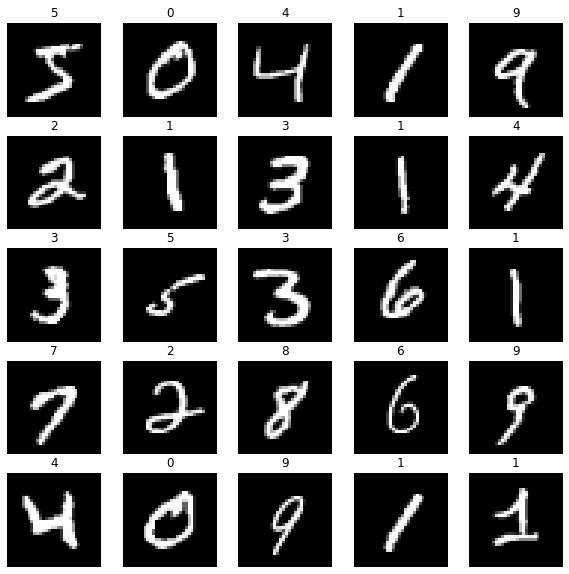

In [224]:
def show_images(dataset):
    plt.figure(figsize=(10,10))
    data, labels = dataset
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(data[i, :, :, :], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')

show_images(train_dataset)

В качестве модели будем использовать упрощенный аналог LeNet.

In [232]:
layers = [
    tf.keras.layers.Conv2D(6, (5, 5), strides=1, activation='tanh', input_shape=(32, 32, 3), data_format='channels_last'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(16, (5, 5), strides=1, activation='tanh'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation=tf.nn.tanh),
    tf.keras.layers.Dense(84, activation=tf.nn.tanh),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

In [237]:
model = Model(layers=layers)
history = model.evaluate(train_dataset, test_dataset)

----------------------------------------------------------------------------------------
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_50 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_51 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 120)               48120     
______________________________

Точность модели довольно неплохая - 0.998 на обучающей и 0.989 на тестовой выборках.

### Задание 2.После уточнения модели на синтетических данных попробуйте обучить ее на реальных данных (набор Google Street View). Что изменилось в модели?

In [279]:
from scipy.io import loadmat

In [280]:
train_dataset = loadmat(f'./Datasets/4/train_32x32.mat')

train_x = train_dataset['X']
train_y = train_dataset['y'][:, 0]

In [281]:
test_dataset = loadmat(f'./Datasets/4/test_32x32.mat')

test_x = test_dataset['X']
test_y = test_dataset['y'][:, 0]

In [282]:
train_x = train_x.swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0)
test_x = test_x.swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0)

In [295]:
train_y = np.mod(train_y, np.full(train_y.shape[0], 10))
test_y = np.mod(test_y, np.full(test_y.shape[0], 10))

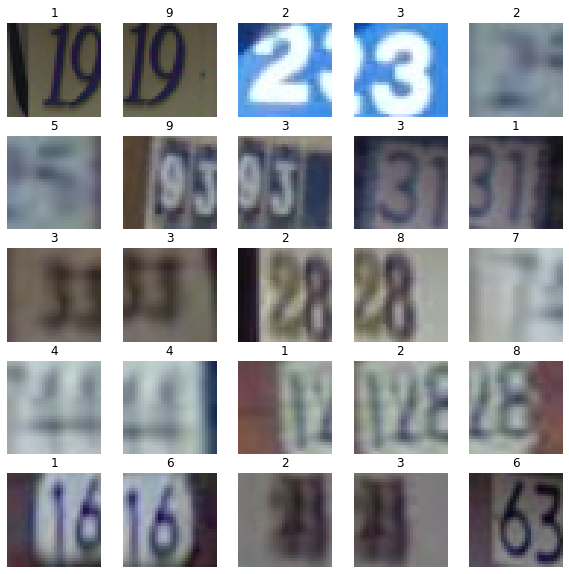

In [296]:
show_images((train_x, train_y))

In [298]:
history = model.evaluate((train_x, train_y), (test_x, test_y))

Train on 73257 samples
Epoch 1/10
73257/73257 [==============================] - 11s 152us/sample - loss: 0.5829 - accuracy: 0.8178
Epoch 2/10
73257/73257 [==============================] - 11s 153us/sample - loss: 0.5924 - accuracy: 0.8120
Epoch 3/10
73257/73257 [==============================] - 12s 158us/sample - loss: 0.5645 - accuracy: 0.8236
Epoch 4/10
73257/73257 [==============================] - 12s 167us/sample - loss: 0.6040 - accuracy: 0.8090
Epoch 5/10
73257/73257 [==============================] - 12s 167us/sample - loss: 0.5821 - accuracy: 0.8156
Epoch 6/10
73257/73257 [==============================] - 12s 167us/sample - loss: 0.5523 - accuracy: 0.8263
Epoch 7/10
73257/73257 [==============================] - 12s 167us/sample - loss: 0.5979 - accuracy: 0.8106
Epoch 8/10
73257/73257 [==============================] - 12s 167us/sample - loss: 0.5577 - accuracy: 0.8255
Epoch 9/10
73257/73257 [==============================] - 12s 167us/sample - loss: 0.5451 - accuracy: 0.8

### Задание 3. Сделайте множество снимков изображений номеров домов с помощью смартфона на ОС Android. 

### Задание 4. Реализуйте приложение для ОС Android, которое может распознавать цифры в номерах домов, используя разработанный ранее классификатор. Какова доля правильных классификаций?